In [1]:
from skimage.transform import radon, iradon
import pydicom as dicom
import numpy as np
import os
from glob import glob
import re
import matplotlib.pyplot as plt

In [3]:
high_metal_folder = [
            sorted(
                glob(
                    os.path.join(path, "high_metal/acquisition_" + str(i) + "/*")
                ),
                key=lambda x: [
                    int(c) if c.isdigit() else c for c in re.split(r"(\d+)", x)
                ],
            )
            for i in range(11)
        ]
high_metal_folder[1][:5]

['../data/dicom/high_metal/acquisition_1/001.dcm',
 '../data/dicom/high_metal/acquisition_1/002.dcm',
 '../data/dicom/high_metal/acquisition_1/003.dcm',
 '../data/dicom/high_metal/acquisition_1/004.dcm',
 '../data/dicom/high_metal/acquisition_1/005.dcm']

/Users/hugo/opt/miniconda3/envs/artefact/lib/python3.9/site-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


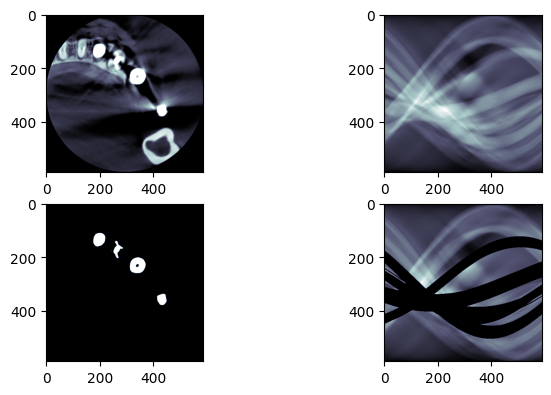

In [4]:
y = dicom.dcmread(high_metal_folder[1][200]).pixel_array
theta = np.linspace(0.0, 180.0, max(y.shape), endpoint=False)
y = y / max(y.flatten()) 
metal = y >=1
sinogram_y = radon(y, theta=theta, circle=True)
sinogram_metal = radon(metal, theta=theta, circle=True)
sinogram_without_metal = (1-sinogram_metal>=1)*sinogram_y
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(8, 4.5))
ax1[0].imshow(y, cmap=plt.cm.bone)
ax2[0].imshow(metal, cmap=plt.cm.bone, )

ax1[1].imshow(sinogram_y, cmap=plt.cm.bone)
ax2[1].imshow(sinogram_without_metal, cmap=plt.cm.bone)

/Users/hugo/opt/miniconda3/envs/artefact/lib/python3.9/site-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


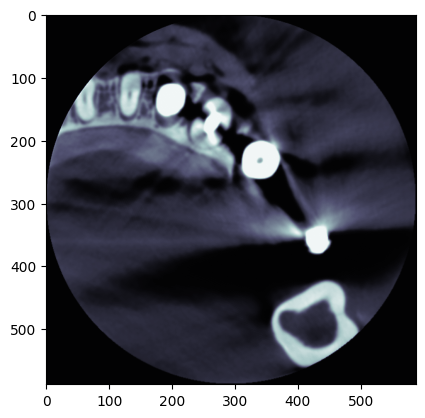

In [5]:
y = dicom.dcmread(high_metal_folder[1][200])
x = radon(y.pixel_array, theta=theta, circle=True)
x = iradon(x, theta=theta, circle=True)
plt.imshow(x, cmap=plt.cm.bone)

/Users/hugo/opt/miniconda3/envs/artefact/lib/python3.9/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:250: UserWarning: The length of the pixel data in the dataset (2765952 bytes) indicates it contains excess padding. 2074464 bytes will be removed from the end of the data
  warnings.warn(msg)


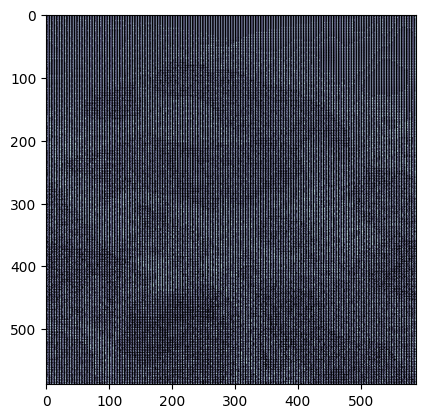

In [11]:
from pydicom.pixel_data_handlers.util import apply_modality_lut

y = dicom.dcmread(high_metal_folder[1][200])
x = apply_modality_lut(y.pixel_array, y)



/Users/hugo/opt/miniconda3/envs/artefact/lib/python3.9/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:250: UserWarning: The length of the pixel data in the dataset (2765952 bytes) indicates it contains excess padding. 2074464 bytes will be removed from the end of the data
  warnings.warn(msg)


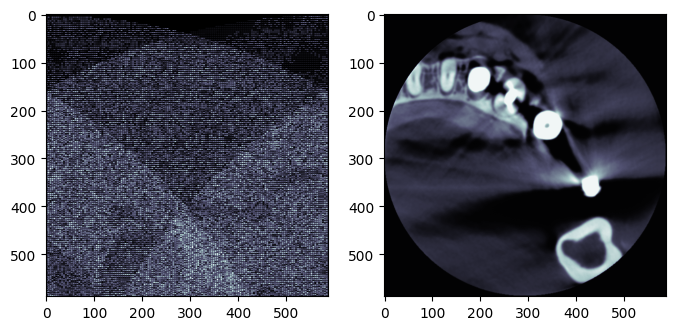

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
ax1.imshow(y.pixel_array, cmap=plt.cm.bone)
ax2.imshow(x, cmap=plt.cm.bone)

In [ ]:
y.save_as(r"out.dcm", write_like_original=False)

In [12]:
y = dicom.dcmread(high_metal_folder[1][200])


AttributeError: 'Dataset' object has no attribute '_parent_encoding'